# Analyzing the College Football Portal

In [1]:
# Importing libraries

from __future__ import print_function
import time
import cfbd
from cfbd.rest import ApiException
from pprint import pprint

import requests
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

# Displaying more rows and columns to be able to scan through more of the data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Creating the Transfer Portal Dataframe

In [2]:
headers = {"Authorization": "Bearer YOUR_API_KEY"}

# Creating the portal dataframe through a for loop of a list of years, in case I want to also look at additional years
years = [2022]
portal_df = pd.DataFrame([])

for year in years:
    portal_response = requests.get("https://api.collegefootballdata.com/player/portal?", headers = headers, params = {"year": year})
    portal_json = portal_response.json()
    temp_df = pd.DataFrame.from_dict(portal_json)
    portal_df = portal_df.append(temp_df, ignore_index=True,sort = False)

portal_df.head()

,season,firstName,lastName,position,origin,destination,transferDate,rating,stars,eligibility
0,2022,Troy,dela Vega,TE,Utah State,None,2022-05-01T02:49:00.000Z,None,2.0,Immediate
1,2022,Josh,Tracey,WR,Connecticut,None,2022-05-01T01:42:00.000Z,None,3.0,Immediate
2,2022,Ty,Lindenman,WR,Illinois,None,2022-05-01T01:38:00.000Z,None,NaN,Immediate
3,2022,Owen,Hickey,WR,Illinois,None,2022-05-01T01:37:00.000Z,None,NaN,Immediate
4,2022,Ken,Torain,CB,Duke,None,2022-05-01T01:37:00.000Z,None,3.0,Immediate


In [3]:
# Cleaning up the column names
new_columns = {"firstName": "first_name", "lastName": "last_name", "transferDate": "transfer_date"}
portal_df.rename(columns = new_columns, inplace = True)
portal_df.columns

Index(['season', 'first_name', 'last_name', 'position', 'origin',
       'destination', 'transfer_date', 'rating', 'stars', 'eligibility'],
      dtype='object')

In [4]:
# Look at data types of the columns to check if any data types should be changed
print(portal_df.info())

# transfer_date should be changed to date
# rating should be changed to a float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season         2097 non-null   int64  
 1   first_name     2097 non-null   object 
 2   last_name      2097 non-null   object 
 3   position       2097 non-null   object 
 4   origin         2097 non-null   object 
 5   destination    1008 non-null   object 
 6   transfer_date  2097 non-null   object 
 7   rating         973 non-null    object 
 8   stars          1903 non-null   float64
 9   eligibility    2097 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 164.0+ KB
None


In [5]:
portal_df['transfer_date'] = pd.to_datetime(portal_df['transfer_date']).dt.normalize()

portal_df['rating'] = pd.to_numeric(portal_df['rating'], errors = "coerce")

portal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   season         2097 non-null   int64              
 1   first_name     2097 non-null   object             
 2   last_name      2097 non-null   object             
 3   position       2097 non-null   object             
 4   origin         2097 non-null   object             
 5   destination    1008 non-null   object             
 6   transfer_date  2097 non-null   datetime64[ns, UTC]
 7   rating         973 non-null    float64            
 8   stars          1903 non-null   float64            
 9   eligibility    2097 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(6)
memory usage: 164.0+ KB


In [6]:
# Creating a column to store the player's full name

portal_df['name'] = portal_df['first_name'] + " " + portal_df['last_name']
portal_df.head()

,season,first_name,last_name,position,origin,destination,transfer_date,rating,stars,eligibility,name
0,2022,Troy,dela Vega,TE,Utah State,None,2022-05-01 00:00:00+00:00,NaN,2.0,Immediate,Troy dela Vega
1,2022,Josh,Tracey,WR,Connecticut,None,2022-05-01 00:00:00+00:00,NaN,3.0,Immediate,Josh Tracey
2,2022,Ty,Lindenman,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,NaN,Immediate,Ty Lindenman
3,2022,Owen,Hickey,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,NaN,Immediate,Owen Hickey
4,2022,Ken,Torain,CB,Duke,None,2022-05-01 00:00:00+00:00,NaN,3.0,Immediate,Ken Torain


In [7]:
# Creating a column that concatenates the player's name and their origin school
# This will serve as an id that links the portal to the roster dataframe, which will provide the player's hometown location

portal_df['concat'] = portal_df['name'] + "-" + portal_df['origin']
portal_df['pos_concat'] = portal_df['name'] + "-" + portal_df['position']

In [8]:
portal_df['concat'] = portal_df['concat'].str.replace('Intl','International')

In [9]:
# Create a Decision column by using the function below to get a sense of whether players have transferred yet

def decision(portal_df):
    if portal_df['origin'] == portal_df['destination']:
        return "Staying"
    elif portal_df['destination'] == None:
        return "Undecided"
    elif portal_df['origin'] != portal_df['destination']:
        return "Transferred"
    
portal_df['decision'] = portal_df.apply(decision, axis = 1)

portal_df.head()

,season,first_name,last_name,position,origin,destination,transfer_date,rating,stars,eligibility,name,concat,pos_concat,decision
0,2022,Troy,dela Vega,TE,Utah State,None,2022-05-01 00:00:00+00:00,NaN,2.0,Immediate,Troy dela Vega,Troy dela Vega-Utah State,Troy dela Vega-TE,Undecided
1,2022,Josh,Tracey,WR,Connecticut,None,2022-05-01 00:00:00+00:00,NaN,3.0,Immediate,Josh Tracey,Josh Tracey-Connecticut,Josh Tracey-WR,Undecided
2,2022,Ty,Lindenman,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,NaN,Immediate,Ty Lindenman,Ty Lindenman-Illinois,Ty Lindenman-WR,Undecided
3,2022,Owen,Hickey,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,NaN,Immediate,Owen Hickey,Owen Hickey-Illinois,Owen Hickey-WR,Undecided
4,2022,Ken,Torain,CB,Duke,None,2022-05-01 00:00:00+00:00,NaN,3.0,Immediate,Ken Torain,Ken Torain-Duke,Ken Torain-CB,Undecided


In [10]:
portal_df['origin'] = portal_df['origin'].replace(['Florida Intl'], 'Florida International')
portal_df['destination'] = portal_df['destination'].replace(['Florida Intl'], 'Florida International')
portal_df.head()

,season,first_name,last_name,position,origin,destination,transfer_date,rating,stars,eligibility,name,concat,pos_concat,decision
0,2022,Troy,dela Vega,TE,Utah State,None,2022-05-01 00:00:00+00:00,NaN,2.0,Immediate,Troy dela Vega,Troy dela Vega-Utah State,Troy dela Vega-TE,Undecided
1,2022,Josh,Tracey,WR,Connecticut,None,2022-05-01 00:00:00+00:00,NaN,3.0,Immediate,Josh Tracey,Josh Tracey-Connecticut,Josh Tracey-WR,Undecided
2,2022,Ty,Lindenman,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,NaN,Immediate,Ty Lindenman,Ty Lindenman-Illinois,Ty Lindenman-WR,Undecided
3,2022,Owen,Hickey,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,NaN,Immediate,Owen Hickey,Owen Hickey-Illinois,Owen Hickey-WR,Undecided
4,2022,Ken,Torain,CB,Duke,None,2022-05-01 00:00:00+00:00,NaN,3.0,Immediate,Ken Torain,Ken Torain-Duke,Ken Torain-CB,Undecided


#### Plotting the Running Total of Player Entries into the Transfer Portal

In [11]:
dates_df = portal_df.groupby(['transfer_date']).size().reset_index().rename(columns={0:'count'})
dates_df['running_total'] = dates_df['count'].cumsum()
dates_df.head()

,transfer_date,count,running_total
0,2021-08-01 00:00:00+00:00,2,2
1,2021-08-02 00:00:00+00:00,3,5
2,2021-08-03 00:00:00+00:00,1,6
3,2021-08-04 00:00:00+00:00,4,10
4,2021-08-05 00:00:00+00:00,4,14


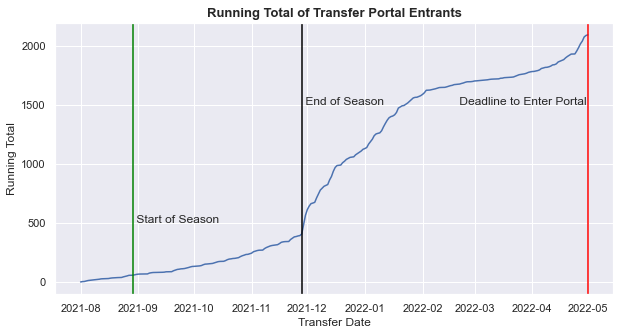

In [12]:
plt.rcParams["figure.figsize"] = [10,5]
sns.set_style("darkgrid")

sns.lineplot(data=dates_df,x='transfer_date',y='running_total')
plt.xlabel('Transfer Date')
plt.ylabel('Running Total')
plt.title('Running Total of Transfer Portal Entrants',fontweight = 'bold', fontsize = 13)

# Including reference lines to mark the start/end of the season and the deadline to enter the portal

plt.axvline(x = pd.Timestamp(2021, 8, 29), color = 'green')
plt.axvline(x= pd.Timestamp(2021,11,28),color='black')
plt.axvline(x= pd.Timestamp(2022,5,1),color='red')
plt.text(x=pd.Timestamp(2021,8,29),y=500,s=" Start of Season")
plt.text(x=pd.Timestamp(2021,11,28),y=1500,s=" End of Season")
plt.text(x=pd.Timestamp(2022,2,19),y=1500,s=" Deadline to Enter Portal")
plt.show()

**Thoughts**

The biggest spike in portal entrants came at the end of November/beginning of December, which marks the end of the regular season. This makes sense, given that players wanting to transfer will most likely play out their season and then look to make a move as soon as the season is over so that they can maximize the time they have to decide on their next school and maximize the time they have to acclimate to their new school.

#### The Transfer Portal by Stars

In [13]:
portal_df['stars'].value_counts(dropna=False)

3.0    1444
2.0     291
NaN     194
4.0     158
5.0       7
1.0       3
Name: stars, dtype: int64

Given that the API data for the transfer portal comes directly from 247 Sports, we can assume that the athletes with no stars listed did not have any stars when coming out of high school/JUCO. For our analysis, we can convert the nulls to 0.

In [14]:
portal_df['stars'] = portal_df['stars'].fillna(0)
portal_df['stars'] = portal_df['stars'].astype(int)
portal_df['stars'].value_counts()

3    1444
2     291
0     194
4     158
5       7
1       3
Name: stars, dtype: int64

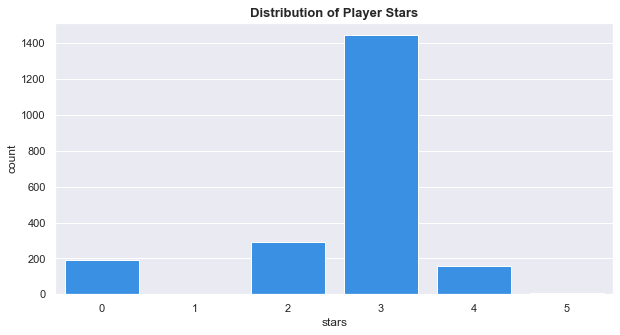

In [15]:
sns.countplot(x='stars',data=portal_df, color='dodgerblue')
plt.title('Distribution of Player Stars',fontweight = 'bold', fontsize = 13)
plt.show()

By far, most of the players entering the transfer portal were 3 star recruits coming out of high school/JUCO. There are only a handful of 5 star recruits that have entered the portal, however this may not be too surprising given that very few players are given 5 stars during the initial recruiting process.

#### The Transfer Portal by Decision

With the new decision column, I'd like to get a visual of what the % breakdown is between undecided, transferred, and staying.

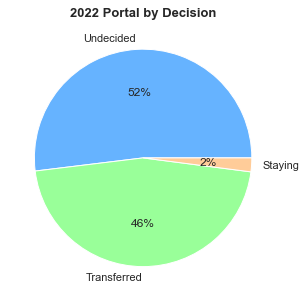

In [16]:
plt.rcParams["figure.figsize"] = [5,5]
colors = ['#66b3ff','#99ff99','#ffcc99']
portal_df[portal_df['season'] == 2022]['decision'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=colors)
plt.ylabel('')
plt.title(label = '2022 Portal by Decision', fontweight = 'bold', fontsize = 13)
plt.show()

While the % of players that are officially staying put is quite low, I would suspect that the true number might end up higher given the large % of players that are still undecided. When a player enters the transfer portal, it is not always a certainty that he transfers, so the possibility remains that he returns to the same school.

#### Top Schools by Outgoing/Incoming Transfers
We can use the origin/destination columns and filter out any players that are officially staying.

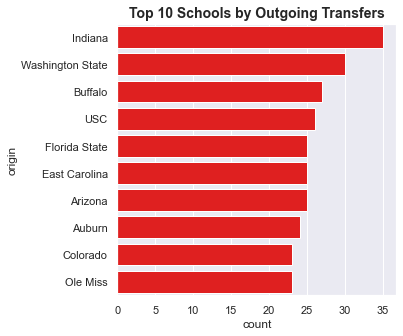

In [17]:
origin_group = portal_df[portal_df['decision']!='Staying']
origin_group = portal_df.groupby(['origin']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count',ascending=False).head(10)
sns.barplot(y='origin',x='count',data=origin_group,color= 'red')
plt.title('Top 10 Schools by Outgoing Transfers', fontweight='bold', fontsize=14)
plt.show()

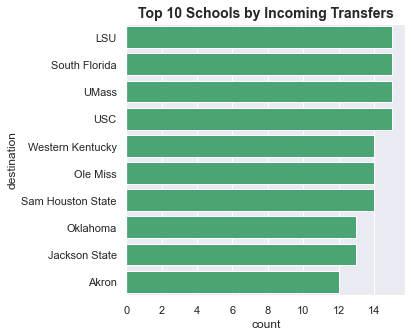

In [18]:
dest_group = portal_df[portal_df['decision']!='Staying']
dest_group = portal_df.groupby(['destination']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count',ascending=False).head(10)
sns.barplot(y='destination',x='count',data=dest_group,color= 'mediumseagreen')
plt.title('Top 10 Schools by Incoming Transfers', fontweight='bold', fontsize=14)
plt.show()

**The Transfer Portal by Position/Position Group**  

Looking at the list of positions, there are some positions that are unclear as to what they are. Some players are given more specialized position titles instead of their more standardized titles. For example, "PRO" and "DUAL" refer to styles of quarterback. Below, I will group some of the positions together by their more common title, and then categorize them into larger groups based on whether they play offense, defense, or special teams.

In [19]:
portal_df['position'].value_counts()

WR      322
LB      235
CB      231
DL      188
QB      184
S       176
RB      176
OT      138
IOL     125
EDGE     97
TE       90
K        38
ATH      29
P        19
LS       10
OLB       8
SDE       6
ILB       6
OG        6
WDE       5
PRO       4
DUAL      2
OC        1
DT        1
Name: position, dtype: int64

In [20]:
# Simplifying some of the positions by grouping them together
def position(portal_df):
    if portal_df['position'] == 'PRO' or portal_df['position'] == 'DUAL':
        return 'QB'
    elif portal_df['position'] == 'SDE' or portal_df['position'] == 'WDE':
        return 'DE'
    elif portal_df['position'] == 'APB':
        return 'RB'
    else:
        return portal_df['position']

    
portal_df['position'] = portal_df.apply(position, axis = 1)

In [21]:
# Creating a function to group positions into offense, defense, and special teams
offense = ['QB', 'WR', 'RB', 'TE', 'OT', 'OG', 'IOL', 'OC', 'ATH', 'APB']
defense = ['CB', 'LB', 'DL', 'S', 'EDGE', 'DT', 'DE', 'ILB', 'OLB']
special_teams = ['K', 'P', 'KOS', 'H', 'LS']

def pos_group(portal_df):
    if portal_df['position'] in offense:
        return 'Offense'
    elif portal_df['position'] in defense:
        return 'Defense'
    elif portal_df['position'] in special_teams:
        return 'Special Teams'

In [22]:
portal_df['position_group'] = portal_df.apply(pos_group, axis = 1)

# Ensure that all positions have been grouped
portal_df['position_group'].value_counts(dropna=False)

Offense          1077
Defense           953
Special Teams      67
Name: position_group, dtype: int64

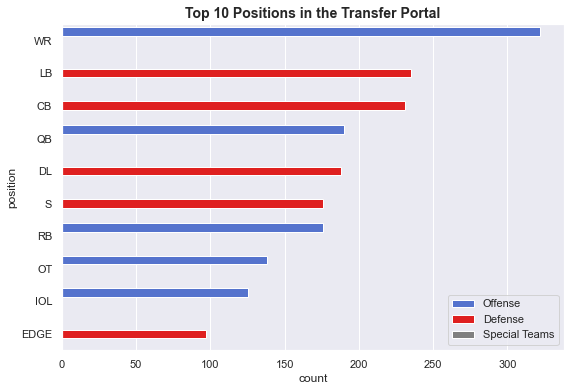

In [23]:
# Graphing the top 10 positions in the transfer portal

plt.rcParams["figure.figsize"] = [9,6]
colors = ['royalblue','red','gray']
sns.countplot(y='position',data=portal_df, hue = 'position_group',
             order = portal_df['position'].value_counts().iloc[:10].index, 
             palette=colors)
plt.legend(loc='lower right')
plt.title('Top 10 Positions in the Transfer Portal', fontweight='bold', fontsize=14)
plt.show()

In [24]:
# Grouping the df by position group to make a pie chart
position_group = portal_df.groupby(['position_group']).size().reset_index().rename(columns={0:'count'})
position_group

,position_group,count
0,Defense,953
1,Offense,1077
2,Special Teams,67


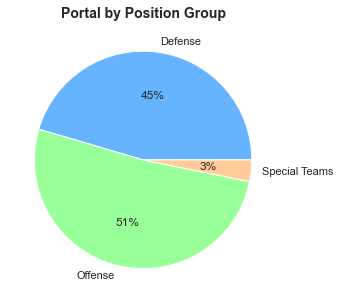

In [25]:
# Graphing a pie chart of the breakdown by position group
colors = ['#66b3ff','#99ff99','#ffcc99']

plt.rcParams["figure.figsize"] = [5,5]
plt.pie(position_group['count'], labels = position_group['position_group'],colors = colors,autopct='%.0f%%')
plt.ylabel('')
plt.title('Portal by Position Group', fontweight= 'bold', fontsize = 14)

plt.show()

## Creating the Team Dataframes
This dataframe will aid our analysis in providing the school's location. Because we want the location of both the school that the player is transferring from and the school the player is transferring to, we will need to create two duplicate dataframes. One dataframe will provide the location for the origin school, and the other will provide the location for the destination school.

In [26]:
team_response = requests.get("https://api.collegefootballdata.com/teams", headers = headers)
team_json = team_response.json()
team_df = pd.DataFrame(team_json)
team_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741 entries, 0 to 1740
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1741 non-null   int64 
 1   school        1741 non-null   object
 2   mascot        854 non-null    object
 3   abbreviation  785 non-null    object
 4   alt_name1     40 non-null     object
 5   alt_name2     785 non-null    object
 6   alt_name3     833 non-null    object
 7   conference    646 non-null    object
 8   division      100 non-null    object
 9   color         721 non-null    object
 10  alt_color     244 non-null    object
 11  logos         759 non-null    object
 12  location      1741 non-null   object
dtypes: int64(1), object(12)
memory usage: 176.9+ KB


In [27]:
team_df.head()

,id,school,mascot,abbreviation,alt_name1,alt_name2,alt_name3,conference,division,color,alt_color,logos,location
0,2000,Abilene Christian,Wildcats,ACU,None,ACU,Abil Christian,AWC,None,#4e2683,#ebebeb,[http://a.espncdn.com/i/teamlogos/ncaa/500/200...,"{'venue_id': None, 'name': None, 'city': None,..."
1,2001,Adams State,Grizzlies,ADST,None,ADST,Adams St,Rocky Mountain,None,#000000,None,[http://a.espncdn.com/i/teamlogos/ncaa/500/200...,"{'venue_id': None, 'name': None, 'city': None,..."
2,2003,Adrian,Bulldogs,ADR,None,ADR,Adrian,Michigan,None,#000000,None,[http://a.espncdn.com/i/teamlogos/ncaa/500/200...,"{'venue_id': None, 'name': None, 'city': None,..."
3,2005,Air Force,Falcons,AFA,None,AFA,Air Force,Mountain West,Mountain,#004a7b,#ffffff,[http://a.espncdn.com/i/teamlogos/ncaa/500/200...,"{'venue_id': 3713, 'name': 'Falcon Stadium', '..."
4,2006,Akron,Zips,AKR,None,AKR,Akron,Mid-American,East,#00285e,#84754e,[http://a.espncdn.com/i/teamlogos/ncaa/500/200...,"{'venue_id': 3768, 'name': 'Summa Field at Inf..."


In [28]:
# Looking at the location column above, the location details are stored in a dictionary, making them harder to retrieve
# Below, I am converting the keys into series and adding them to the dataframe as separate series

team_df = pd.concat([team_df.drop(['location'], axis=1), team_df['location'].apply(pd.Series)], axis=1)
team_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741 entries, 0 to 1740
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1741 non-null   int64  
 1   school            1741 non-null   object 
 2   mascot            854 non-null    object 
 3   abbreviation      785 non-null    object 
 4   alt_name1         40 non-null     object 
 5   alt_name2         785 non-null    object 
 6   alt_name3         833 non-null    object 
 7   conference        646 non-null    object 
 8   division          100 non-null    object 
 9   color             721 non-null    object 
 10  alt_color         244 non-null    object 
 11  logos             759 non-null    object 
 12  venue_id          213 non-null    float64
 13  name              213 non-null    object 
 14  city              213 non-null    object 
 15  state             213 non-null    object 
 16  zip               213 non-null    object 


In [29]:
# Filtering dataframe to keep only desired columns
team_df = team_df[['school', 'mascot', 'city', 'state', 'latitude', 'longitude']]

In [30]:
team_df[team_df['latitude'].isnull()]

,school,mascot,city,state,latitude,longitude
0,Abilene Christian,Wildcats,None,None,NaN,NaN
1,Adams State,Grizzlies,None,None,NaN,NaN
2,Adrian,Bulldogs,None,None,NaN,NaN
6,Alabama A&M,Bulldogs,None,None,NaN,NaN
9,Albany State (GA),Golden Rams,None,None,NaN,NaN
10,Albion,Britons,None,None,NaN,NaN
11,Albright,Lions,None,None,NaN,NaN
13,Alderson-Broaddus,Battlers,None,None,NaN,NaN
14,Alfred,Saxons,None,None,NaN,NaN
15,Alfred State College,Pioneers,None,None,NaN,NaN


Looking at the schools with null location, all of these schools appear to be FCS or outside Division 1. We can use geopy to fill in the lat/long info for the FCS teams which were web scraped from Wikipedia. The notebook with the web scraping is located in the same repository as this notebook.

In [31]:
fcs = pd.read_csv(r'Documents\FCS Teams.csv')
fcs.head()

,Team_FCS,City_FCS,State_FCS,Latitude_FCS,Longitude_FCS
0,Abilene Christian,Abilene,TX,32.469973,-99.707360
1,Alabama A&M,Normal,AL,34.783895,-86.568423
2,Alabama State,Montgomery,AL,32.363350,-86.293551
3,Albany,Albany,NY,42.651167,-73.754968
4,Alcorn State,Lorman,MS,31.876749,-91.141797


In [32]:
# Merging the dataframes to receive location info on FCS teams
team_df = pd.merge(team_df, fcs, left_on = 'school', right_on = 'Team_FCS', how = 'left')
team_df[team_df['latitude'].isnull()]

,school,mascot,city,state,latitude,longitude,Team_FCS,City_FCS,State_FCS,Latitude_FCS,Longitude_FCS
0,Abilene Christian,Wildcats,None,None,NaN,NaN,Abilene Christian,Abilene,TX,32.469973,-99.707360
1,Adams State,Grizzlies,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Adrian,Bulldogs,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Alabama A&M,Bulldogs,None,None,NaN,NaN,Alabama A&M,Normal,AL,34.783895,-86.568423
9,Albany State (GA),Golden Rams,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Albion,Britons,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Albright,Lions,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Alderson-Broaddus,Battlers,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Alfred,Saxons,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,Alfred State College,Pioneers,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Populating the null location columns with the values from the FCS location columns
team_locs = ['city', 'state', 'latitude', 'longitude']
fcs_locs = ['City_FCS', 'State_FCS', 'Latitude_FCS', 'Longitude_FCS']
team_df[team_locs] = np.where(team_df[team_locs].isnull(), team_df[fcs_locs], team_df[team_locs])

In [34]:
# Dropping the FCS columns now that we have populated our original lat/long columns for FCS teams
team_df.drop(['Team_FCS','City_FCS', 'State_FCS', 'Latitude_FCS', 'Longitude_FCS'], inplace = True, axis = 1)
team_df.head()

,school,mascot,city,state,latitude,longitude
0,Abilene Christian,Wildcats,Abilene,TX,32.469973,-99.70736
1,Adams State,Grizzlies,NaN,NaN,NaN,NaN
2,Adrian,Bulldogs,NaN,NaN,NaN,NaN
3,Air Force,Falcons,Colorado Springs,CO,38.99697,-104.843616
4,Akron,Zips,Akron,OH,41.072553,-81.508341


In [35]:
# Making a copy of the dataframe to be merged with the portal df on the destination field
destination = team_df.copy()
destination = destination.add_suffix("_dest")
destination.columns

Index(['school_dest', 'mascot_dest', 'city_dest', 'state_dest',
       'latitude_dest', 'longitude_dest'],
      dtype='object')

In [36]:
# Making a copy of the dataframe to be merged with the portal df on the origin field
origin = team_df.copy()
origin = origin.add_suffix("_origin")
origin.columns

Index(['school_origin', 'mascot_origin', 'city_origin', 'state_origin',
       'latitude_origin', 'longitude_origin'],
      dtype='object')

In [37]:
# Joining the portal with the origin dataframe
# This will add location details of the origin school

combined_df = pd.merge(portal_df, origin, left_on = 'origin', right_on = 'school_origin', how = 'left')
combined_df.head()

,season,first_name,last_name,position,origin,destination,transfer_date,rating,stars,eligibility,name,concat,pos_concat,decision,position_group,school_origin,mascot_origin,city_origin,state_origin,latitude_origin,longitude_origin
0,2022,Troy,dela Vega,TE,Utah State,None,2022-05-01 00:00:00+00:00,NaN,2,Immediate,Troy dela Vega,Troy dela Vega-Utah State,Troy dela Vega-TE,Undecided,Offense,Utah State,Aggies,Logan,UT,41.751739,-111.811601
1,2022,Josh,Tracey,WR,Connecticut,None,2022-05-01 00:00:00+00:00,NaN,3,Immediate,Josh Tracey,Josh Tracey-Connecticut,Josh Tracey-WR,Undecided,Offense,Connecticut,Huskies,East Hartford,CT,41.759568,-72.618773
2,2022,Ty,Lindenman,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,0,Immediate,Ty Lindenman,Ty Lindenman-Illinois,Ty Lindenman-WR,Undecided,Offense,Illinois,Fighting Illini,Lexington,VA,37.788983,-79.43505
3,2022,Owen,Hickey,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,0,Immediate,Owen Hickey,Owen Hickey-Illinois,Owen Hickey-WR,Undecided,Offense,Illinois,Fighting Illini,Lexington,VA,37.788983,-79.43505
4,2022,Ken,Torain,CB,Duke,None,2022-05-01 00:00:00+00:00,NaN,3,Immediate,Ken Torain,Ken Torain-Duke,Ken Torain-CB,Undecided,Defense,Duke,Blue Devils,Durham,NC,35.995369,-78.941756


In [38]:
# Checking which schools don't have lat/long info. None of these appear to be Division 1 schools

no_origin_loc = combined_df[combined_df['latitude_origin'].isnull()]
print(str(no_origin_loc['school_origin'].value_counts().sum()) + " schools")
print(no_origin_loc['school_origin'].value_counts())

#These schools are all outside of Division 1, so we can just filter them out of our Tableau mapping analysis

12 schools
Texas A&M Commerce            2
Simon Fraser                  1
Savannah State                1
West Texas A&M                1
Northern State                1
Minnesota State Mankato       1
West Florida                  1
Livingstone College           1
Shepherd                      1
Southern Connecticut State    1
Kentucky Christian            1
Name: school_origin, dtype: int64


In [39]:
# Merging the destination dataframe
# This will add location details of the destination school

combined_df = pd.merge(combined_df, destination, left_on = 'destination', right_on = 'school_dest', how = 'left')
combined_df.head()

,season,first_name,last_name,position,origin,destination,transfer_date,rating,stars,eligibility,name,concat,pos_concat,decision,position_group,school_origin,mascot_origin,city_origin,state_origin,latitude_origin,longitude_origin,school_dest,mascot_dest,city_dest,state_dest,latitude_dest,longitude_dest
0,2022,Troy,dela Vega,TE,Utah State,None,2022-05-01 00:00:00+00:00,NaN,2,Immediate,Troy dela Vega,Troy dela Vega-Utah State,Troy dela Vega-TE,Undecided,Offense,Utah State,Aggies,Logan,UT,41.751739,-111.811601,NaN,NaN,NaN,NaN,NaN,NaN
1,2022,Josh,Tracey,WR,Connecticut,None,2022-05-01 00:00:00+00:00,NaN,3,Immediate,Josh Tracey,Josh Tracey-Connecticut,Josh Tracey-WR,Undecided,Offense,Connecticut,Huskies,East Hartford,CT,41.759568,-72.618773,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,Ty,Lindenman,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,0,Immediate,Ty Lindenman,Ty Lindenman-Illinois,Ty Lindenman-WR,Undecided,Offense,Illinois,Fighting Illini,Lexington,VA,37.788983,-79.43505,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,Owen,Hickey,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,0,Immediate,Owen Hickey,Owen Hickey-Illinois,Owen Hickey-WR,Undecided,Offense,Illinois,Fighting Illini,Lexington,VA,37.788983,-79.43505,NaN,NaN,NaN,NaN,NaN,NaN
4,2022,Ken,Torain,CB,Duke,None,2022-05-01 00:00:00+00:00,NaN,3,Immediate,Ken Torain,Ken Torain-Duke,Ken Torain-CB,Undecided,Defense,Duke,Blue Devils,Durham,NC,35.995369,-78.941756,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Checking which schools dont have lat/long info. None of these appear to be Division 1 schools

no_dest_loc = combined_df[combined_df['latitude_dest'].isnull()]
print(str(no_dest_loc['school_dest'].value_counts().sum()) + " schools")
print(no_dest_loc['school_dest'].value_counts())

36 schools
Blinn College                  4
Elizabeth City State           2
Trinity Valley C.C.            2
Professional                   2
Iowa Western C.C.              2
Texas A&M Commerce             2
West Florida                   1
Winston-Salem State            1
Utah Tech                      1
Pittsburg State                1
Western New Mexico             1
Valdosta State                 1
Cisco College                  1
Tiffin University              1
Grand Valley State             1
Ashland                        1
Eastern New Mexico             1
Limestone College              1
St. Thomas University          1
Butler County (KS)             1
Delta State                    1
Southern Arkansas              1
Colorado School of Mines       1
Iowa Central C.C.              1
Lindenwood University          1
Merrimack                      1
Southwestern Oklahoma State    1
Tyler J.C.                     1
Name: school_dest, dtype: int64


## Creating the Coaches Dataframe
This dataframe will allow us to determine what % of transfer portal entrants are from schools with coaching changes. Loading in a file with the latest list of head coaches.

In [41]:
coach_df = pd.read_csv(r'Documents\Coaches.csv')
coach_df.head(10)

,School,Conference,Coach,First season,W,L,Games Played,Subdivision,Power 5
0,Air Force,Mountain West,Troy Calhoun,2007,111.0,75.0,186.0,FBS,False
1,Akron,MAC,Joe Moorhead,2022,0.0,0.0,0.0,FBS,False
2,Alabama,SEC,Nick Saban,2007,177.0,25.0,202.0,FBS,True
3,Appalachian State,Sun Belt,Shawn Clark,2020,20.0,7.0,27.0,FBS,False
4,Arizona State,Pac-12,Herm Edwards,2018,25.0,18.0,43.0,FBS,True
5,Arizona,Pac-12,Jedd Fisch,2021,1.0,11.0,12.0,FBS,True
6,Arkansas,SEC,Sam Pittman,2020,12.0,11.0,23.0,FBS,True
7,Arkansas State,Sun Belt,Butch Jones,2021,2.0,10.0,12.0,FBS,False
8,Army,Independent,Jeff Monken,2014,58.0,42.0,100.0,FBS,False
9,Auburn,SEC,Bryan Harsin,2021,6.0,7.0,13.0,FBS,True


In [42]:
# Clean up column names
coach_df.columns = coach_df.columns.str.lower().str.replace(" ","_")

In [43]:
# To indicate whether there has been a recent coaching change, we will classify new coaches using two conditions
    # First season = 2022 OR
    # First season = 2021 AND Games Played < 12
# The second condition will account for any teams that made a coaching change in the middle of the 2021 season

coach_df['coach_change'] = (coach_df['first_season'] == 2022) | ((coach_df['first_season'] == 2021) & (coach_df['games_played'] < 12))
coach_df.head()

,school,conference,coach,first_season,w,l,games_played,subdivision,power_5,coach_change
0,Air Force,Mountain West,Troy Calhoun,2007,111.0,75.0,186.0,FBS,False,False
1,Akron,MAC,Joe Moorhead,2022,0.0,0.0,0.0,FBS,False,True
2,Alabama,SEC,Nick Saban,2007,177.0,25.0,202.0,FBS,True,False
3,Appalachian State,Sun Belt,Shawn Clark,2020,20.0,7.0,27.0,FBS,False,False
4,Arizona State,Pac-12,Herm Edwards,2018,25.0,18.0,43.0,FBS,True,False


In [44]:
# Making a copy of the dataframe to be merged with the portal df on the Origin field
coach_origin_df = coach_df.copy()
coach_origin_df = coach_origin_df.add_suffix('_origin')

In [45]:
# Making a copy of the dataframe to be merged with the portal df on the Destination field
coach_dest_df = coach_df.copy()
coach_dest_df = coach_dest_df.add_suffix('_dest')

In [46]:
# Merging the coach_origin dataframe
combined_df = pd.merge(combined_df, coach_origin_df[['school_origin','coach_origin','conference_origin','subdivision_origin','power_5_origin','coach_change_origin']], left_on = 'origin', right_on = 'school_origin', how = 'left')
combined_df.head()

,season,first_name,last_name,position,origin,destination,transfer_date,rating,stars,eligibility,name,concat,pos_concat,decision,position_group,school_origin_x,mascot_origin,city_origin,state_origin,latitude_origin,longitude_origin,school_dest,mascot_dest,city_dest,state_dest,latitude_dest,longitude_dest,school_origin_y,coach_origin,conference_origin,subdivision_origin,power_5_origin,coach_change_origin
0,2022,Troy,dela Vega,TE,Utah State,None,2022-05-01 00:00:00+00:00,NaN,2,Immediate,Troy dela Vega,Troy dela Vega-Utah State,Troy dela Vega-TE,Undecided,Offense,Utah State,Aggies,Logan,UT,41.751739,-111.811601,NaN,NaN,NaN,NaN,NaN,NaN,Utah State,Blake Anderson,Mountain West,FBS,False,False
1,2022,Josh,Tracey,WR,Connecticut,None,2022-05-01 00:00:00+00:00,NaN,3,Immediate,Josh Tracey,Josh Tracey-Connecticut,Josh Tracey-WR,Undecided,Offense,Connecticut,Huskies,East Hartford,CT,41.759568,-72.618773,NaN,NaN,NaN,NaN,NaN,NaN,Connecticut,Jim L. Mora,Independent,FBS,False,True
2,2022,Ty,Lindenman,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,0,Immediate,Ty Lindenman,Ty Lindenman-Illinois,Ty Lindenman-WR,Undecided,Offense,Illinois,Fighting Illini,Lexington,VA,37.788983,-79.43505,NaN,NaN,NaN,NaN,NaN,NaN,Illinois,Bret Bielema,Big Ten,FBS,True,False
3,2022,Owen,Hickey,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,0,Immediate,Owen Hickey,Owen Hickey-Illinois,Owen Hickey-WR,Undecided,Offense,Illinois,Fighting Illini,Lexington,VA,37.788983,-79.43505,NaN,NaN,NaN,NaN,NaN,NaN,Illinois,Bret Bielema,Big Ten,FBS,True,False
4,2022,Ken,Torain,CB,Duke,None,2022-05-01 00:00:00+00:00,NaN,3,Immediate,Ken Torain,Ken Torain-Duke,Ken Torain-CB,Undecided,Defense,Duke,Blue Devils,Durham,NC,35.995369,-78.941756,NaN,NaN,NaN,NaN,NaN,NaN,Duke,Mike Elko,ACC,FBS,True,True


In [47]:
# Merging the coach_dest dataframe
combined_df = pd.merge(combined_df, coach_dest_df[['school_dest','coach_dest','conference_dest','subdivision_dest','power_5_dest','coach_change_dest']], left_on = 'destination', right_on = 'school_dest', how = 'left')
combined_df.head()

,season,first_name,last_name,position,origin,destination,transfer_date,rating,stars,eligibility,name,concat,pos_concat,decision,position_group,school_origin_x,mascot_origin,city_origin,state_origin,latitude_origin,longitude_origin,school_dest_x,mascot_dest,city_dest,state_dest,latitude_dest,longitude_dest,school_origin_y,coach_origin,conference_origin,subdivision_origin,power_5_origin,coach_change_origin,school_dest_y,coach_dest,conference_dest,subdivision_dest,power_5_dest,coach_change_dest
0,2022,Troy,dela Vega,TE,Utah State,None,2022-05-01 00:00:00+00:00,NaN,2,Immediate,Troy dela Vega,Troy dela Vega-Utah State,Troy dela Vega-TE,Undecided,Offense,Utah State,Aggies,Logan,UT,41.751739,-111.811601,NaN,NaN,NaN,NaN,NaN,NaN,Utah State,Blake Anderson,Mountain West,FBS,False,False,NaN,NaN,NaN,NaN,NaN,NaN
1,2022,Josh,Tracey,WR,Connecticut,None,2022-05-01 00:00:00+00:00,NaN,3,Immediate,Josh Tracey,Josh Tracey-Connecticut,Josh Tracey-WR,Undecided,Offense,Connecticut,Huskies,East Hartford,CT,41.759568,-72.618773,NaN,NaN,NaN,NaN,NaN,NaN,Connecticut,Jim L. Mora,Independent,FBS,False,True,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,Ty,Lindenman,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,0,Immediate,Ty Lindenman,Ty Lindenman-Illinois,Ty Lindenman-WR,Undecided,Offense,Illinois,Fighting Illini,Lexington,VA,37.788983,-79.43505,NaN,NaN,NaN,NaN,NaN,NaN,Illinois,Bret Bielema,Big Ten,FBS,True,False,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,Owen,Hickey,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,0,Immediate,Owen Hickey,Owen Hickey-Illinois,Owen Hickey-WR,Undecided,Offense,Illinois,Fighting Illini,Lexington,VA,37.788983,-79.43505,NaN,NaN,NaN,NaN,NaN,NaN,Illinois,Bret Bielema,Big Ten,FBS,True,False,NaN,NaN,NaN,NaN,NaN,NaN
4,2022,Ken,Torain,CB,Duke,None,2022-05-01 00:00:00+00:00,NaN,3,Immediate,Ken Torain,Ken Torain-Duke,Ken Torain-CB,Undecided,Defense,Duke,Blue Devils,Durham,NC,35.995369,-78.941756,NaN,NaN,NaN,NaN,NaN,NaN,Duke,Mike Elko,ACC,FBS,True,True,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# Creating a column that tells me if there has been a coaching change at either the origin or destination
combined_df['any_coach_change'] = (combined_df['coach_change_origin']==True)|(combined_df['coach_change_dest']==True)

In [49]:
# Drop duplicate columns 
dupe_cols = [col for col in combined_df.columns if '_x' in col or '_y' in col]
combined_df.drop(dupe_cols,axis=1,inplace=True)

#### What % of transfer portal entrants have had a coaching change at either their old or new school?

In [50]:
coach_change = combined_df.groupby(['any_coach_change']).size().reset_index().rename(columns={0:'count'})
coach_change

,any_coach_change,count
0,False,1431
1,True,672


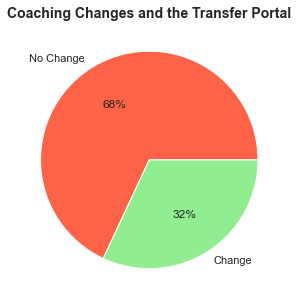

In [51]:
plt.pie(coach_change['count'],labels=['No Change','Change'],
        colors = ['tomato','lightgreen'],autopct='%.0f%%')
plt.title('Coaching Changes and the Transfer Portal', fontweight= 'bold', fontsize = 14)
plt.show()

**Thoughts**<br>

Over 30% of the portal entrants can say that they've had a coaching change come into play in their transfer situation. When a coaching change happens on the current team, a player may no longer feel that their role is secure going forward with a new coach, or simply, they would rather have their pick of who they would rather be coached by.

## Creating the Team Record Dataframe

In [52]:
record_response = requests.get("https://api.collegefootballdata.com/records?year=2021", headers = headers)
record_json = record_response.json()
record_df = pd.DataFrame(record_json)
record_df.head()

,year,team,conference,division,expectedWins,total,conferenceGames,homeGames,awayGames
0,2021,Air Force,Mountain West,Mountain,9.1,"{'games': 13, 'wins': 10, 'losses': 3, 'ties': 0}","{'games': 8, 'wins': 6, 'losses': 2, 'ties': 0}","{'games': 6, 'wins': 4, 'losses': 2, 'ties': 0}","{'games': 5, 'wins': 5, 'losses': 0, 'ties': 0}"
1,2021,Akron,Mid-American,East,1.9,"{'games': 12, 'wins': 2, 'losses': 10, 'ties': 0}","{'games': 8, 'wins': 1, 'losses': 7, 'ties': 0}","{'games': 6, 'wins': 1, 'losses': 5, 'ties': 0}","{'games': 6, 'wins': 1, 'losses': 5, 'ties': 0}"
2,2021,Alabama,SEC,West,11.0,"{'games': 15, 'wins': 13, 'losses': 2, 'ties': 0}","{'games': 9, 'wins': 8, 'losses': 1, 'ties': 0}","{'games': 7, 'wins': 7, 'losses': 0, 'ties': 0}","{'games': 4, 'wins': 3, 'losses': 1, 'ties': 0}"
3,2021,Appalachian State,Sun Belt,,11.3,"{'games': 14, 'wins': 10, 'losses': 4, 'ties': 0}","{'games': 9, 'wins': 7, 'losses': 2, 'ties': 0}","{'games': 7, 'wins': 7, 'losses': 0, 'ties': 0}","{'games': 6, 'wins': 3, 'losses': 3, 'ties': 0}"
4,2021,Arizona,Pac-12,South,1.9,"{'games': 12, 'wins': 1, 'losses': 11, 'ties': 0}","{'games': 9, 'wins': 1, 'losses': 8, 'ties': 0}","{'games': 6, 'wins': 1, 'losses': 5, 'ties': 0}","{'games': 5, 'wins': 0, 'losses': 5, 'ties': 0}"


In [53]:
# Record details are stored in a dictionary, so I will convert the key-values to series
record_df = pd.concat([record_df.drop(['total'], axis=1), record_df['total'].apply(pd.Series)], axis=1)

In [54]:
record_df.drop(['division', 'expectedWins','conferenceGames', 'homeGames', 'awayGames', 'ties'], inplace = True, axis = 1)
record_df.head()

,year,team,conference,games,wins,losses
0,2021,Air Force,Mountain West,13,10,3
1,2021,Akron,Mid-American,12,2,10
2,2021,Alabama,SEC,15,13,2
3,2021,Appalachian State,Sun Belt,14,10,4
4,2021,Arizona,Pac-12,12,1,11


In [55]:
record_df['win_pct'] = record_df['wins']/record_df['games']
record_df.head()

,year,team,conference,games,wins,losses,win_pct
0,2021,Air Force,Mountain West,13,10,3,0.769231
1,2021,Akron,Mid-American,12,2,10,0.166667
2,2021,Alabama,SEC,15,13,2,0.866667
3,2021,Appalachian State,Sun Belt,14,10,4,0.714286
4,2021,Arizona,Pac-12,12,1,11,0.083333


In [56]:
# This dataframe currently only contains records for FBS teams. 
# I will copy and paste a record list for FCS teams into a csv and concatenate the two dataframes together

fcs_df = pd.read_csv(r'Documents\FCS Records.csv')
fcs_df.head(10)

,year,team,games,wins,losses,win_pct
0,2021,Abilene Christian,11,5,6,0.454545
1,2021,Alabama A&M,10,7,3,0.700000
2,2021,Alabama State,11,5,6,0.454545
3,2021,Albany,11,2,9,0.181818
4,2021,Alcorn State,11,6,5,0.545455
5,2021,Arkansas-Pine Bluff,11,2,9,0.181818
6,2021,Austin Peay,11,6,5,0.545455
7,2021,Bethune-Cookman,11,2,9,0.181818
8,2021,Brown,10,2,8,0.200000
9,2021,Bryant,11,7,4,0.636364


In [57]:
# Concatenate the two dataframes
combined_record = pd.concat([record_df, fcs_df], ignore_index = True)
combined_record.head()

,year,team,conference,games,wins,losses,win_pct
0,2021,Air Force,Mountain West,13,10,3,0.769231
1,2021,Akron,Mid-American,12,2,10,0.166667
2,2021,Alabama,SEC,15,13,2,0.866667
3,2021,Appalachian State,Sun Belt,14,10,4,0.714286
4,2021,Arizona,Pac-12,12,1,11,0.083333


In [58]:
# Merging the record dataframe
combined_df = pd.merge(combined_df, combined_record[['team','games','wins','losses','win_pct']], left_on = 'origin', right_on = 'team', how = 'left')
combined_df.head()

,season,first_name,last_name,position,origin,destination,transfer_date,rating,stars,eligibility,name,concat,pos_concat,decision,position_group,mascot_origin,city_origin,state_origin,latitude_origin,longitude_origin,mascot_dest,city_dest,state_dest,latitude_dest,longitude_dest,coach_origin,conference_origin,subdivision_origin,power_5_origin,coach_change_origin,coach_dest,conference_dest,subdivision_dest,power_5_dest,coach_change_dest,any_coach_change,team,games,wins,losses,win_pct
0,2022,Troy,dela Vega,TE,Utah State,None,2022-05-01 00:00:00+00:00,NaN,2,Immediate,Troy dela Vega,Troy dela Vega-Utah State,Troy dela Vega-TE,Undecided,Offense,Aggies,Logan,UT,41.751739,-111.811601,NaN,NaN,NaN,NaN,NaN,Blake Anderson,Mountain West,FBS,False,False,NaN,NaN,NaN,NaN,NaN,False,Utah State,14.0,11.0,3.0,0.785714
1,2022,Josh,Tracey,WR,Connecticut,None,2022-05-01 00:00:00+00:00,NaN,3,Immediate,Josh Tracey,Josh Tracey-Connecticut,Josh Tracey-WR,Undecided,Offense,Huskies,East Hartford,CT,41.759568,-72.618773,NaN,NaN,NaN,NaN,NaN,Jim L. Mora,Independent,FBS,False,True,NaN,NaN,NaN,NaN,NaN,True,Connecticut,12.0,1.0,11.0,0.083333
2,2022,Ty,Lindenman,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,0,Immediate,Ty Lindenman,Ty Lindenman-Illinois,Ty Lindenman-WR,Undecided,Offense,Fighting Illini,Lexington,VA,37.788983,-79.43505,NaN,NaN,NaN,NaN,NaN,Bret Bielema,Big Ten,FBS,True,False,NaN,NaN,NaN,NaN,NaN,False,Illinois,12.0,5.0,7.0,0.416667
3,2022,Owen,Hickey,WR,Illinois,None,2022-05-01 00:00:00+00:00,NaN,0,Immediate,Owen Hickey,Owen Hickey-Illinois,Owen Hickey-WR,Undecided,Offense,Fighting Illini,Lexington,VA,37.788983,-79.43505,NaN,NaN,NaN,NaN,NaN,Bret Bielema,Big Ten,FBS,True,False,NaN,NaN,NaN,NaN,NaN,False,Illinois,12.0,5.0,7.0,0.416667
4,2022,Ken,Torain,CB,Duke,None,2022-05-01 00:00:00+00:00,NaN,3,Immediate,Ken Torain,Ken Torain-Duke,Ken Torain-CB,Undecided,Defense,Blue Devils,Durham,NC,35.995369,-78.941756,NaN,NaN,NaN,NaN,NaN,Mike Elko,ACC,FBS,True,True,NaN,NaN,NaN,NaN,NaN,True,Duke,12.0,3.0,9.0,0.250000


In [59]:
# Checking which teams dont have a record available
# None of these teams are Division 1, so we won't worry about imputing values for our analysis

combined_df[combined_df['win_pct'].isnull()]

,season,first_name,last_name,position,origin,destination,transfer_date,rating,stars,eligibility,name,concat,pos_concat,decision,position_group,mascot_origin,city_origin,state_origin,latitude_origin,longitude_origin,mascot_dest,city_dest,state_dest,latitude_dest,longitude_dest,coach_origin,conference_origin,subdivision_origin,power_5_origin,coach_change_origin,coach_dest,conference_dest,subdivision_dest,power_5_dest,coach_change_dest,any_coach_change,team,games,wins,losses,win_pct
30,2022,Malachi,Ledbetter,EDGE,Simon Fraser,Washington State,2022-01-10 00:00:00+00:00,NaN,0,Immediate,Malachi Ledbetter,Malachi Ledbetter-Simon Fraser,Malachi Ledbetter-EDGE,Transferred,Defense,Clansmen,NaN,NaN,NaN,NaN,Cougars,Pullman,WA,46.731831,-117.160499,NaN,NaN,NaN,NaN,NaN,Jake Dickert,Pac-12,FBS,True,True,True,NaN,NaN,NaN,NaN,NaN
158,2022,Connor,Vasher,IOL,Savannah State,UMass,2022-02-01 00:00:00+00:00,NaN,0,Immediate,Connor Vasher,Connor Vasher-Savannah State,Connor Vasher-IOL,Transferred,Offense,Tigers,NaN,NaN,NaN,NaN,Minutemen,Hadley,MA,42.377324,-72.536059,NaN,NaN,NaN,NaN,NaN,Don Brown,Independent,FBS,False,True,True,NaN,NaN,NaN,NaN,NaN
309,2022,Parker,Hanna,OT,West Texas A&M,Indiana,2022-03-31 00:00:00+00:00,NaN,0,Immediate,Parker Hanna,Parker Hanna-West Texas A&M,Parker Hanna-OT,Transferred,Offense,Buffaloes,NaN,NaN,NaN,NaN,Hoosiers,Bloomington,IN,39.180896,-86.525622,NaN,NaN,NaN,NaN,NaN,Tom Allen,Big Ten,FBS,True,False,False,NaN,NaN,NaN,NaN,NaN
347,2022,Emmit,Bohle,OT,Northern State,Arizona State,2021-11-23 00:00:00+00:00,0.85,3,Immediate,Emmit Bohle,Emmit Bohle-Northern State,Emmit Bohle-OT,Transferred,Offense,Wolves,NaN,NaN,NaN,NaN,Sun Devils,Tempe,AZ,33.426447,-111.932501,NaN,NaN,NaN,NaN,NaN,Herm Edwards,Pac-12,FBS,True,False,False,NaN,NaN,NaN,NaN,NaN
409,2022,Terrell,Jennings,CB,Minnesota State Mankato,Illinois,2022-04-15 00:00:00+00:00,NaN,0,Immediate,Terrell Jennings,Terrell Jennings-Minnesota State Mankato,Terrell Jennings-CB,Transferred,Defense,None,NaN,NaN,NaN,NaN,Fighting Illini,Lexington,VA,37.788983,-79.43505,NaN,NaN,NaN,NaN,NaN,Bret Bielema,Big Ten,FBS,True,False,False,NaN,NaN,NaN,NaN,NaN
443,2022,Austin,Reed,QB,West Florida,Western Kentucky,2022-02-23 00:00:00+00:00,NaN,0,Immediate,Austin Reed,Austin Reed-West Florida,Austin Reed-QB,Transferred,Offense,Argonauts,NaN,NaN,NaN,NaN,Hilltoppers,Bowling Green,KY,36.98479,-86.459404,NaN,NaN,NaN,NaN,NaN,Tyson Helton,C-USA,FBS,False,False,False,NaN,NaN,NaN,NaN,NaN
536,2022,Jordan,Robinson,CB,Livingstone College,Kentucky,2022-03-28 00:00:00+00:00,NaN,0,Immediate,Jordan Robinson,Jordan Robinson-Livingstone College,Jordan Robinson-CB,Transferred,Defense,None,NaN,NaN,NaN,NaN,Wildcats,Lexington,KY,38.02209,-84.505341,NaN,NaN,NaN,NaN,NaN,Mark Stoops,SEC,FBS,True,False,False,NaN,NaN,NaN,NaN,NaN
598,2022,Richard,West,IOL,Texas A&M Commerce,Texas State,2021-11-18 00:00:00+00:00,0.81,3,Immediate,Richard West,Richard West-Texas A&M Commerce,Richard West-IOL,Transferred,Offense,None,NaN,NaN,NaN,NaN,Bobcats,San Marcos,TX,29.891001,-97.925573,NaN,NaN,NaN,NaN,NaN,Jake Spavital,Sun Belt,FBS,False,False,False,NaN,NaN,NaN,NaN,NaN
599,2022,Richard,West,IOL,Texas A&M Commerce,Texas State,2021-11-18 00:00:00+00:00,0.81,3,Immediate,Richard West,Richard West-Texas A&M Commerce,Richard West-IOL,Transferred,Offense,None,NaN,NaN,NaN,NaN,Bobcats,San Marcos,TX,29.891001,-97.925573,NaN,NaN,NaN,NaN,NaN,Jake Spavital,Sun Belt,FBS,False,False,False,NaN,NaN,NaN,NaN,NaN
1136,2022,Tyson,Bagent,QB,Shepherd,None,2022-01-07 00:00:00+00:00,NaN,0,Immediate,Tyson Bagent,Tyson Bagent-Shepherd,Tyson Bagent-QB,Undecided,Offense,Rams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN


#### Plotting the # of Outgoing Transfers vs Win Percentage
Can we observe a relationship between the two measures?

In [60]:
origin_group = combined_df[combined_df['decision']!='Staying']
origin_group = origin_group.groupby(['origin'])[['win_pct']].agg(['count','max']).reset_index()
origin_group.columns = ['origin','players','win_pct']
origin_group.head()

,origin,players,win_pct
0,Abilene Christian,4,0.454545
1,Air Force,8,0.769231
2,Akron,10,0.166667
3,Alabama,22,0.866667
4,Alabama A&M,1,0.700000


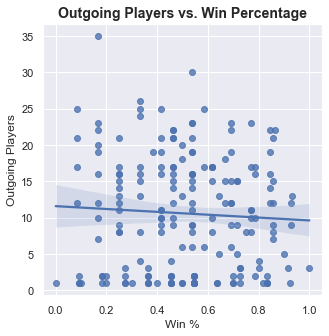

In [61]:
sns.regplot(data=origin_group, x='win_pct',y='players')
plt.title('Outgoing Players vs. Win Percentage', fontweight= 'bold', fontsize = 14)
plt.xlabel('Win %')
plt.ylabel('Outgoing Players')
plt.show()

In [62]:
print('The correlation between win_pct and # of transfers is: {}'.format(origin_group['win_pct'].corr(origin_group['players'])))

The correlation between win_pct and # of transfers is: -0.057142121053000795


**Thoughts** <br>
With the lack of a correlation shown in the plot and coefficient above, we can't see any relationship between win percentage and the # of players transfering out. However, this dataframe contains players from FCS teams, which represents the lower tier of Division 1 college football, where players might be looking to make the jump up to the FBS regardless of their FCS team record. If we just look at the Power 5 FBS schools (teams from the top 5 conferences in Division 1), can we observe a stronger relationship?

#### Plotting the # of Outgoing Transfers vs Win Percentage - Power 5 Schools

In [63]:
pfive_win = combined_df[(combined_df['decision']!='Staying') & (combined_df['power_5_origin'])]
pfive_win = pfive_win.groupby(['origin'])[['win_pct']].agg(['count','max']).reset_index()
pfive_win.columns = ['origin','players','win_pct']
pfive_win.head()

,origin,players,win_pct
0,Alabama,22,0.866667
1,Arizona,25,0.083333
2,Arizona State,17,0.615385
3,Arkansas,22,0.692308
4,Auburn,22,0.461538


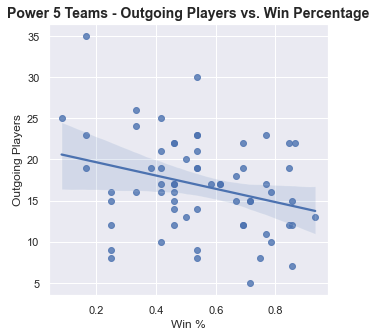

In [64]:
sns.regplot(data=pfive_win, x='win_pct',y='players')
plt.title('Power 5 Teams - Outgoing Players vs. Win Percentage', fontweight= 'bold', fontsize = 14)
plt.xlabel('Win %')
plt.ylabel('Outgoing Players')
plt.show()

In [65]:
print('The correlation between win_pct and # of transfers is: {}'.format(pfive_win['win_pct'].corr(pfive_win['players'])))

The correlation between win_pct and # of transfers is: -0.2934061177100881


**Thoughts**<br>
When narrowing the dataset to just Power 5 teams, the relationship is a bit stronger, but still only shows a weak correlation. Instead of analyzing win percentage vs # of outgoing transfers, it might be more informative if we compare transfer numbers with player usage metrics.

## Creating the Roster Dataframe
This dataframe will provide us with the hometown info for transferring players

In [66]:
# Looping through the last 3 years of rosters to capture players who may have been injured/redshirted and not listed on most recent roster

years = [2021, 2020, 2019]
roster = pd.DataFrame([])

for year in years:
    roster_response = requests.get("https://api.collegefootballdata.com/roster", headers = headers, params = {"year": year})
    roster_json = roster_response.json()
    temp_roster = pd.DataFrame.from_dict(roster_json)
    roster = roster.append(temp_roster, ignore_index=True,sort = False)

roster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53367 entries, 0 to 53366
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                53367 non-null  object 
 1   first_name        51337 non-null  object 
 2   last_name         51337 non-null  object 
 3   team              53367 non-null  object 
 4   weight            48482 non-null  float64
 5   height            48600 non-null  float64
 6   jersey            47753 non-null  float64
 7   year              46262 non-null  float64
 8   position          49305 non-null  object 
 9   home_city         47553 non-null  object 
 10  home_state        47292 non-null  object 
 11  home_country      47559 non-null  object 
 12  home_latitude     46818 non-null  object 
 13  home_longitude    46818 non-null  object 
 14  home_county_fips  46801 non-null  object 
 15  recruit_ids       53367 non-null  object 
dtypes: float64(4), object(12)
memory usage: 

In [67]:
# Remove rows with no player names

roster = roster[(roster['first_name'].notnull())]
roster = roster.drop(['weight','height','jersey','home_county_fips','recruit_ids'], axis = 1)
roster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51337 entries, 0 to 53366
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              51337 non-null  object 
 1   first_name      51337 non-null  object 
 2   last_name       51337 non-null  object 
 3   team            51337 non-null  object 
 4   year            45699 non-null  float64
 5   position        48742 non-null  object 
 6   home_city       47550 non-null  object 
 7   home_state      47289 non-null  object 
 8   home_country    47556 non-null  object 
 9   home_latitude   46815 non-null  object 
 10  home_longitude  46815 non-null  object 
dtypes: float64(1), object(10)
memory usage: 4.7+ MB


In [68]:
# Creating a column containing the full name
# Creating a column with a concatenate of the full name and the team that will serve as an ID to merge on with the portal df

roster['name'] = roster['first_name'] + " " + roster['last_name']
roster['concat'] = roster['name'] + "-" + roster['team']
roster.head(30)

,id,first_name,last_name,team,year,position,home_city,home_state,home_country,home_latitude,home_longitude,name,concat
0,107494,Trey,Sanders,Alabama,2.0,RB,Port Saint Joe,FL,USA,29.8118757,-85.302974,Trey Sanders,Trey Sanders-Alabama
1,110027,Bobby,Bell,Louisiana Monroe,2.0,LB,Bossier City,LA,USA,32.5369356,-93.6952689,Bobby Bell,Bobby Bell-Louisiana Monroe
2,136429,Cedric,Patterson III,Rice,4.0,WR,Crosby,TX,USA,29.9118885,-95.0621941,Cedric Patterson III,Cedric Patterson III-Rice
3,154071,Chris,Woods,Pittsburgh,NaN,None,None,None,None,None,None,Chris Woods,Chris Woods-Pittsburgh
4,161378,Jon,Morrison,North Carolina,NaN,None,None,None,None,None,None,Jon Morrison,Jon Morrison-North Carolina
5,169499,Ryan,Johnson,Akron,NaN,None,None,None,None,None,None,Ryan Johnson,Ryan Johnson-Akron
6,172288,Ryan,Kelley,Eastern Washington,NaN,None,None,None,None,None,None,Ryan Kelley,Ryan Kelley-Eastern Washington
7,241161,TJ,Jones,Western Carolina,NaN,None,None,None,None,None,None,TJ Jones,TJ Jones-Western Carolina
8,479316,Jonathan,Jones,Campbell,NaN,None,None,None,None,None,None,Jonathan Jones,Jonathan Jones-Campbell
10,501312,Justin,Brown,Southern Utah,NaN,WR,None,None,None,None,None,Justin Brown,Justin Brown-Southern Utah


In [69]:
roster = roster.sort_values(by=['concat','id'])
roster.tail(10)

,id,first_name,last_name,team,year,position,home_city,home_state,home_country,home_latitude,home_longitude,name,concat
42280,4250392,Zyon,McCollum,Sam Houston State,NaN,DB,Galveston,TX,USA,29.299328,-94.7945882,Zyon McCollum,Zyon McCollum-Sam Houston State
4053,4361378,Zyon,McGee,Georgia Southern,3.0,LB,Bainbridge,GA,USA,30.9038252,-84.5754768,Zyon McGee,Zyon McGee-Georgia Southern
23714,4361378,Zyon,McGee,Georgia Southern,3.0,LB,Bainbridge,GA,USA,30.9038252,-84.5754768,Zyon McGee,Zyon McGee-Georgia Southern
44520,4361378,Zyon,McGee,Georgia Southern,3.0,LB,Bainbridge,GA,USA,30.9038252,-84.5754768,Zyon McGee,Zyon McGee-Georgia Southern
13081,4608828,Zyon,Walker,South Alabama,1.0,DL,Memphis,TN,USA,35.1490215,-90.0516285,Zyon Walker,Zyon Walker-South Alabama
32162,4608828,Zyon,Walker,South Alabama,1.0,DL,Memphis,TN,USA,35.1490215,-90.0516285,Zyon Walker,Zyon Walker-South Alabama
6499,4383647,Zyquan,Bessant,William & Mary,NaN,None,None,None,None,None,None,Zyquan Bessant,Zyquan Bessant-William & Mary
47877,4383647,Zyquan,Bessant,William & Mary,NaN,None,None,None,None,None,None,Zyquan Bessant,Zyquan Bessant-William & Mary
13734,4683724,Zyrus,Fiaseu,San Diego State,1.0,LB,Las Vegas,NV,USA,36.1672559,-115.1485163,Zyrus Fiaseu,Zyrus Fiaseu-San Diego State
15310,4691318,Zyun,Reeves,NC State,1.0,DL,Winston-salem,NC,USA,36.0998131,-80.2440518,Zyun Reeves,Zyun Reeves-NC State


In [70]:
# Drop any duplicate player rows based on the concat field
roster = roster.drop_duplicates(subset = 'concat', keep = 'first')

In [71]:
combined_df = pd.merge(combined_df, roster[['id', 'concat','home_city','home_state',
                                           'home_country','home_latitude','home_longitude']]
                       ,left_on = 'concat', right_on = 'concat', how = 'left')

## Creating the Usage Dataframe

Player usage is defined as the percentage of offensive plays a player was involved in. Plays within scope include passes, incompletions, rushes, receptions, and targets. Players within scope of usage metrics are skill position players (QB, RB, TE, WR, ATH)

In [72]:
years = [2021, 2020]
usage = pd.DataFrame([])

for year in years:
    usage_response = requests.get("https://api.collegefootballdata.com/player/usage", 
                                  headers = headers, params = {"year": year})
    usage_json = usage_response.json()
    temp_usage = pd.DataFrame.from_dict(usage_json)
    usage = usage.append(temp_usage, ignore_index=True,sort = False)

usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4565 entries, 0 to 4564
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   season      4565 non-null   int64 
 1   id          4565 non-null   object
 2   name        4565 non-null   object
 3   position    4565 non-null   object
 4   team        4565 non-null   object
 5   conference  4565 non-null   object
 6   usage       4565 non-null   object
dtypes: int64(1), object(6)
memory usage: 249.8+ KB


In [73]:
usage['season'].value_counts()

2021    2335
2020    2230
Name: season, dtype: int64

In [74]:
usage.head()

,season,id,name,position,team,conference,usage
0,2021,4566196,Will Rogers,QB,Mississippi State,SEC,"{'overall': 0.7837, 'pass': 0.9959, 'rush': 0...."
1,2021,4370775,Brennan Armstrong,QB,Virginia,ACC,"{'overall': 0.7099, 'pass': 0.9495, 'rush': 0...."
2,2021,4361435,Carson Strong,QB,Nevada,Mountain West,"{'overall': 0.6641, 'pass': 0.965, 'rush': 0.0..."
3,2021,4361653,Devin Leary,QB,NC State,ACC,"{'overall': 0.6341, 'pass': 1.0455, 'rush': 0...."
4,2021,4361994,Sam Hartman,QB,Wake Forest,ACC,"{'overall': 0.6338, 'pass': 1.0561, 'rush': 0...."


In [75]:
# Converting the usage stats from dictionary to series
usage = pd.concat([usage.drop(['usage'], axis=1), usage['usage'].apply(pd.Series)], axis=1)
usage.tail(10)

,season,id,name,position,team,conference,overall,pass,rush,firstDown,secondDown,thirdDown,standardDowns,passingDowns
4555,2020,4036482,Javonis Isaac,TE,Arkansas State,Sun Belt,0.0012,0.0000,0.0028,0.0000,0.000,0.000,0.005,0.000
4556,2020,4427052,Easton Dean,TE,Iowa State,Big 12,0.0012,0.0026,0.0000,0.0026,0.000,0.000,0.000,0.000
4557,2020,4430950,Jefferson Boaz,QB,North Carolina,ACC,0.0012,0.0026,0.0000,0.0024,0.000,0.000,0.000,0.000
4558,2020,4430330,Darien Porter,WR,Iowa State,Big 12,0.0012,0.0026,0.0000,0.0000,0.004,0.000,0.000,0.004
4559,2020,4426797,Paris Brown,RB,Pittsburgh,ACC,0.0012,0.0023,0.0000,0.0029,0.000,0.000,0.000,0.000
4560,2020,4240709,Jake Zilinskas,TE,Pittsburgh,ACC,0.0012,0.0023,0.0000,0.0000,0.000,0.000,0.005,0.000
4561,2020,4259209,Josh Jackson,WR,Clemson,ACC,0.0011,0.0020,0.0000,0.0000,0.000,0.006,0.000,0.004
4562,2020,4241480,Major Tennison,TE,Alabama,SEC,0.0011,0.0023,0.0000,0.0000,0.000,0.007,0.000,0.005
4563,2020,4430823,Thaiu Jones-Bell,WR,Alabama,SEC,0.0011,0.0023,0.0000,0.0000,0.000,0.007,0.004,0.000
4564,2020,4273963,Sylvester Mayers,RB,Clemson,ACC,0.0011,0.0000,0.0026,0.0024,0.000,0.000,0.000,0.000


In [76]:
usage = usage.pivot(index =['id','name'], columns ='season', values =['overall', 'pass', 'rush'])
usage.head()

overall            pass            rush        
season                          2020    2021    2020    2021    2020    2021
id      name                                                                
107494  Trey Sanders          0.0325  0.0734  0.0023  0.0115  0.0621  0.1482
136429  Cedric Patterson III     NaN  0.0637     NaN  0.1343     NaN  0.0091
3682406 Daniel Imatorbhebhe   0.0078  0.0216  0.0194  0.0488  0.0000  0.0000
3707332 Dahu Green            0.0604  0.0220  0.1049  0.0345  0.0000  0.0000
3728271 Bryce Witham          0.0063     NaN  0.0155     NaN  0.0000     NaN

In [77]:
usage.reset_index(inplace=True)
usage.columns = ['id_usage','name_usage','usage_2020', 'usage_2021','pass_usage_2020','pass_usage_2021', 'rush_usage_2020','rush_usage_2021']
usage.head()

,id_usage,name_usage,usage_2020,usage_2021,pass_usage_2020,pass_usage_2021,rush_usage_2020,rush_usage_2021
0,107494,Trey Sanders,0.0325,0.0734,0.0023,0.0115,0.0621,0.1482
1,136429,Cedric Patterson III,NaN,0.0637,NaN,0.1343,NaN,0.0091
2,3682406,Daniel Imatorbhebhe,0.0078,0.0216,0.0194,0.0488,0.0000,0.0000
3,3707332,Dahu Green,0.0604,0.0220,0.1049,0.0345,0.0000,0.0000
4,3728271,Bryce Witham,0.0063,NaN,0.0155,NaN,0.0000,NaN


In [78]:
combined_df = pd.merge(combined_df, usage[['id_usage','usage_2020', 'usage_2021','pass_usage_2020','pass_usage_2021', 'rush_usage_2020','rush_usage_2021']]
                       , left_on = 'id', right_on = 'id_usage', how = 'left')

In [79]:
# Making a smaller dataframe with usage stats and columns from the combined dataframe
player_usage = combined_df[['name','position','position_group','origin','decision','usage_2020','usage_2021',
                            'pass_usage_2020','pass_usage_2021', 'rush_usage_2020','rush_usage_2021']]

In [80]:
# Usage stats are only for offensive skill players, so filtering to only QB, RB, WR, TE, ATH
player_usage = player_usage[player_usage['position'].isin(['QB','WR','TE','RB','ATH'])]

#### How many Offensive players in the transfer portal did not see any usage in 2021?

In [81]:
# Create a column that denotes whether had usage in 2021
player_usage['has_2021'] = ~player_usage['usage_2021'].isnull()

In [82]:
# Group the dataframe to sum the number of players that had/did not have usage in 2021
usage_2021 = player_usage.groupby(['has_2021']).size().reset_index().rename(columns={0:'count'})
usage_2021

,has_2021,count
0,False,470
1,True,339


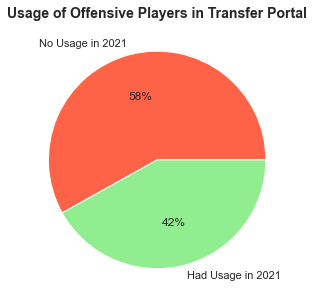

In [83]:
plt.pie(usage_2021['count'],labels=['No Usage in 2021','Had Usage in 2021'],
        colors = ['tomato','lightgreen'],autopct='%.0f%%')
plt.title('Usage of Offensive Players in Transfer Portal', fontweight= 'bold', fontsize = 14)
plt.show()

#### How many Offensive players in the transfer portal saw a drop in usage from 2020?

In [84]:
# Create a column denoting whether the player had usage in 2020 and saw decreased usage in 2021
player_usage['decreased_usage'] = (~player_usage['usage_2020'].isnull())&((player_usage['usage_2021']<player_usage['usage_2020'])|(player_usage['usage_2021'].isnull()))

In [85]:
player_usage['usage_diff'] = player_usage['usage_2020']-player_usage['usage_2021'].fillna(0)
player_usage.head()

,name,position,position_group,origin,decision,usage_2020,usage_2021,pass_usage_2020,pass_usage_2021,rush_usage_2020,rush_usage_2021,has_2021,decreased_usage,usage_diff
0,Troy dela Vega,TE,Offense,Utah State,Undecided,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN
1,Josh Tracey,WR,Offense,Connecticut,Undecided,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN
2,Ty Lindenman,WR,Offense,Illinois,Undecided,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN
3,Owen Hickey,WR,Offense,Illinois,Undecided,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN
9,Sam Reynolds,WR,Offense,South Carolina,Undecided,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN


In [86]:
decreased_usage_df = player_usage[player_usage['decreased_usage']==True]

In [87]:
print('{} of the players that have transferred saw a decrease in usage from 2020 to 2021'.format(len(decreased_usage_df)))

238 of the players that have transferred saw a decrease in usage from 2020 to 2021


#### Comparing Usage for 2020 vs. 2021
Overall, do we notice a sizable decrease in usage between the last two years. Is there a difference in the distribution of usage? Are there many high usage players that entered the portal, or are they predominantly lower usage? 

In [88]:
# Limiting the dataframe to just the total usage columns for each year
usage_years = player_usage[['usage_2020','usage_2021']].dropna()
usage_years.head()

,usage_2020,usage_2021
39,0.0070,0.0109
52,0.0771,0.0033
122,0.0042,0.0026
147,0.0653,0.0071
175,0.0518,0.0300


In [89]:
usage_years.describe()

,usage_2020,usage_2021
count,241.000000,241.000000
mean,0.110768,0.087815
std,0.153801,0.127913
min,0.001400,0.001100
25%,0.018500,0.012200
50%,0.056700,0.038700
75%,0.117600,0.089800
max,0.738500,0.631100


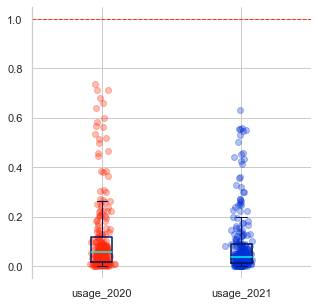

In [90]:
# Creating a scatter box plot to compare the distribution for each year
sns.set_style("whitegrid")

vals, names, xs = [],[],[]

for i, col in enumerate(usage_years.columns):
    vals.append(usage_years[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.03, usage_years[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
    
boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-',color='#01FBEE')
    
plt.boxplot(vals, labels=names, notch=False, boxprops=boxprops, whiskerprops=whiskerprops,
            capprops=capprops, medianprops=medianprops,
            showmeans=False,showfliers=False)

palette = ['#FF2709', '#0030D7'] 

for x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha=0.3, color=c)


sns.despine(bottom=True) # removes right and top axis lines
plt.axhline(y=1, color='#ff3300', linestyle='--', linewidth=1)

plt.show()

**Thoughts**<br>
There is not a sizable overall decrease in usage between the last two seasons, as the median usage lies below 10% for both years. With most players being utilized on less than 20% of offensive plays, we can say that most players entering the transfer portal are low usage players, who presumably are in search of a new team that can provide more playing time.

#### Exploring the Relationship between Avg Usage and # of Portal Entrants

In [91]:
avg_usage = player_usage.groupby(['origin'])['usage_2021'].agg(['mean','count']).reset_index()
avg_usage = avg_usage.fillna(0)
avg_usage = avg_usage[avg_usage['count']>0]
avg_usage.tail()

,origin,mean,count
152,West Virginia,0.177775,4
154,Western Kentucky,0.037780,5
155,Western Michigan,0.039350,2
156,Wisconsin,0.016500,1
157,Wyoming,0.207675,4


In [92]:
print('The correlation between usage and # of transfers is: {}'.format(avg_usage['mean'].corr(avg_usage['count'])))

The correlation between usage and # of transfers is: 0.06577486897872986


**Thoughts**<br>
Based on the little variation of usage values seen in the scatter box plots above, we could probably already tell that there would be no evident relationship between usage and the number of portal entrants by school. Calculating the correlation coeffiencient further confirms that we can observe any relationship.

What might be more helpful is if we had data on the number or percentage of possible plays that a player was on the field. Usage stats are only limited to a handful of football players, so it's hard to make any assumptions that can be generalized about the whole field of player in the transfer portal.